In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess

In [3]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

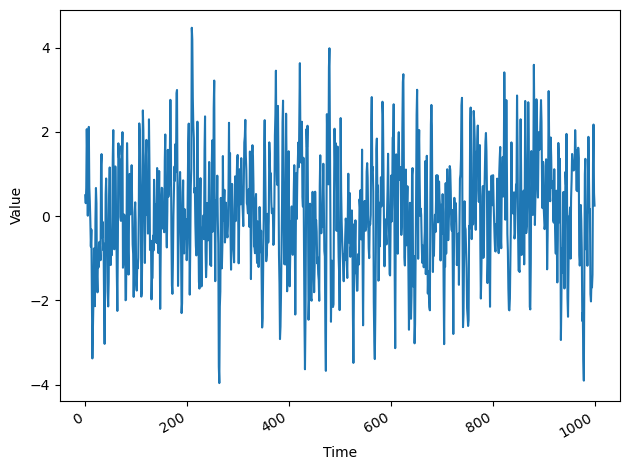

In [10]:
#도식화
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
#ADF 테스트
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(MA2_process)

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-values: {ADF_result[1]}')
#정상

ADF statistic: -14.005444309194491
p-values: 3.795601616713556e-26


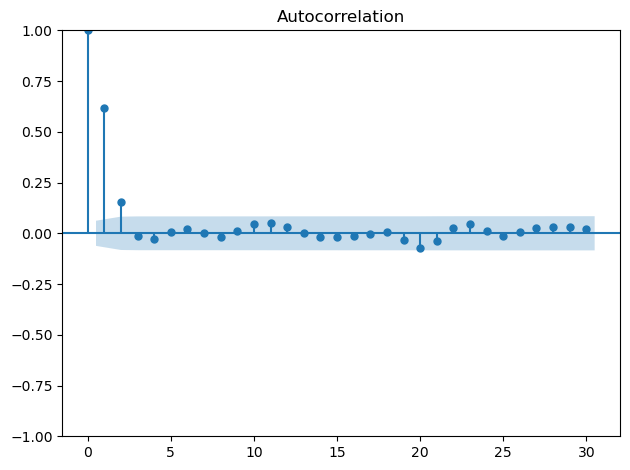

In [13]:
# ACF 도식화
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(MA2_process, lags=30)
plt.tight_layout()

In [15]:
train = MA2_process[:800]
test = MA2_process[int(0.8*len(MA2_process)):]

print(len(train))
print(len(test))

800
200


In [24]:
#Recursive Forecasting(재귀적 예측)은 이전 시점의 예측값을 다음 시점의 입력값으로 사용하는 예측 방식입니다.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def recursive_forecast(df: pd.DataFrame, train_len: int, horizon: int, 
                       window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(MA2_process[:i])
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = MA2_process[:i][-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0, 0, 2)) # MA(q) 모델은 더 복잡한 SARIMAX 모델의 일부다
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [28]:
pred_df = pd.DataFrame()
pred_df['data'] = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = recursive_forecast(MA2_process, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,data,pred_mean,pred_last_value,pred_MA
0,0.973560,-0.017430,0.259693,0.065366
1,0.337338,-0.017430,0.259693,0.017984
2,-0.086834,-0.015752,0.337338,-0.180397
3,-0.530580,-0.015752,0.337338,-0.116820
4,-0.821708,-0.016481,-0.530580,-0.405768


In [29]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['data'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['pred_last_value'], pred_df['pred_mean'])
mse_MA = mean_squared_error(pred_df['pred_MA'], pred_df['pred_mean'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.84917890480208 0.4631544979980527


In [33]:
MA2_process[800]

0.9735598443613067

In [32]:
pred_df['pred_val'] = pd.Series()
pred_df['pred_val'][800:] = MA2_process[800] + pred_df['pred_MA'].cumsum()

/tmp/ipykernel_6622/3645634405.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pred_df['pred_val'][800:] = MA2_process[800] + pred_df['pred_MA'].cumsum()
/tmp/ipykernel_6622/3645634405.py:2: SettingWithCopyWarning: 
A value is trying to 

ValueError: cannot set using a slice indexer with a different length than the value

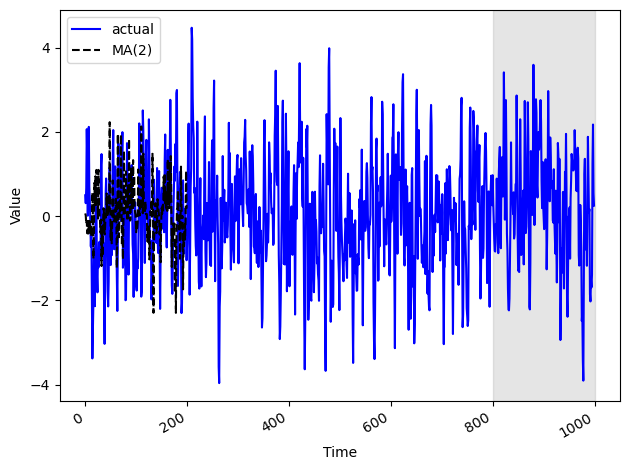

In [31]:
#예측값 도식화
fig, ax = plt.subplots()
ax.plot(MA2_process, 'b-', label = 'actual')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)
#ax.set_xlim(400, 500)


fig.autofmt_xdate()
plt.tight_layout()